# Methods to create model

There are 3 main methods to create a model:
    1. with Sequential
    2. with layer API
    3. with Model
    
The first one is simple for the sequential model.
The second one is powerful for complexe model, as Resnet, InceptionNet
The last one is very dynamic. We need to be very carefully during the construction of model to avoid mistakes.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import *

In [2]:
train_token_path = "./data/imdb/train_token.csv"
test_token_path = "./data/imdb/test_token.csv"

MAX_WORDS = 10000  # We will only consider the top 10,000 words in the dataset
MAX_LEN = 200  # We will cut reviews after 200 words
BATCH_SIZE = 20 

def parse_line(line):
    t = tf.strings.split(line,"\t")
    label = tf.reshape(tf.cast(tf.strings.to_number(t[0]),tf.int32),(-1,))
    features = tf.cast(tf.strings.to_number(tf.strings.split(t[1]," ")),tf.int32)
    return (features,label)

ds_train=  tf.data.TextLineDataset(filenames = [train_token_path]) \
   .map(parse_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

ds_test=  tf.data.TextLineDataset(filenames = [test_token_path]) \
   .map(parse_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

In [3]:
tf.keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN))
model.add(layers.Conv1D(filters = 64,kernel_size = 5,activation = "relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters = 32,kernel_size = 3,activation = "relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation = "sigmoid"))

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 7)            70000     
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [4]:
import datetime
baselogger = callbacks.BaseLogger(stateful_metrics=["AUC"])
logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,validation_data = ds_test,
        epochs = 6,callbacks=[baselogger,tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 19s 19ms/step - loss: 0.5283 - accuracy: 0.6826 - AUC: 0.7859 - val_loss: 0.3326 - val_accuracy: 0.8588 - val_AUC: 0.9331
Epoch 2/6
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2650 - accuracy: 0.8938 - AUC: 0.9574 - val_loss: 0.3181 - val_accuracy: 0.8692 - val_AUC: 0.9427
Epoch 3/6
1000/1000 [==============================] - 13s 13ms/step - loss: 0.1829 - accuracy: 0.9299 - AUC: 0.9796 - val_loss: 0.3582 - val_accuracy: 0.8672 - val_AUC: 0.9399
Epoch 4/6
1000/1000 [==============================] - 13s 13ms/step - loss: 0.1251 - accuracy: 0.9542 - AUC: 0.9899 - val_loss: 0.4207 - val_accuracy: 0.8656 - val_AUC: 0.9354
Epoch 5/6
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0772 - accuracy: 0.9736 - AUC: 0.9958 - val_loss: 0.5367 - val_accuracy: 0.8642 - val_AUC: 0.9277
Epoch 6/6
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0452 - accuracy: 0.9862 - AUC: 0.998

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

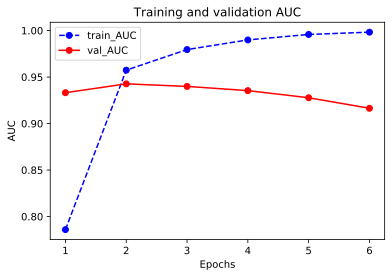

In [6]:
plot_metric(history,"AUC")

In [7]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=[MAX_LEN])
x  = layers.Embedding(MAX_WORDS,7)(inputs)

branch1 = layers.SeparableConv1D(64,3,activation="relu")(x)
branch1 = layers.MaxPool1D(3)(branch1)
branch1 = layers.SeparableConv1D(32,3,activation="relu")(branch1)
branch1 = layers.GlobalMaxPool1D()(branch1)

branch2 = layers.SeparableConv1D(64,5,activation="relu")(x)
branch2 = layers.MaxPool1D(5)(branch2)
branch2 = layers.SeparableConv1D(32,5,activation="relu")(branch2)
branch2 = layers.GlobalMaxPool1D()(branch2)

branch3 = layers.SeparableConv1D(64,7,activation="relu")(x)
branch3 = layers.MaxPool1D(7)(branch3)
branch3 = layers.SeparableConv1D(32,7,activation="relu")(branch3)
branch3 = layers.GlobalMaxPool1D()(branch3)

concat = layers.Concatenate()([branch1,branch2,branch3])
outputs = layers.Dense(1,activation = "sigmoid")(concat)

model = models.Model(inputs = inputs,outputs = outputs)

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 7)       70000       input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 198, 64)      533         embedding[0][0]                  
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 196, 64)      547         embedding[0][0]                  
______________________________________________________________________________________________

In [8]:
class ResBlock(layers.Layer):
    def __init__(self, kernel_size, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self,input_shape):
        self.conv1 = layers.Conv1D(filters=64,kernel_size=self.kernel_size,
                                   activation = "relu",padding="same")
        self.conv2 = layers.Conv1D(filters=32,kernel_size=self.kernel_size,
                                   activation = "relu",padding="same")
        self.conv3 = layers.Conv1D(filters=input_shape[-1],
                                   kernel_size=self.kernel_size,activation = "relu",padding="same")
        self.maxpool = layers.MaxPool1D(2)
        super(ResBlock,self).build(input_shape) # 相当于设置self.built = True

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = layers.Add()([inputs,x])
        x = self.maxpool(x)
        return x

    #如果要让自定义的Layer通过Functional API 组合成模型时可以序列化，需要自定义get_config方法。
    def get_config(self):  
        config = super(ResBlock, self).get_config()
        config.update({'kernel_size': self.kernel_size})
        return config

In [9]:
class ImdbModel(models.Model):
    def __init__(self):
        super(ImdbModel, self).__init__()

    def build(self,input_shape):
        self.embedding = layers.Embedding(MAX_WORDS,7)
        self.block1 = ResBlock(7)
        self.block2 = ResBlock(5)
        self.dense = layers.Dense(1,activation = "sigmoid")
        super(ImdbModel,self).build(input_shape)

    def call(self, x):
        x = self.embedding(x)
        x = self.block1(x)
        x = self.block2(x)
        x = layers.Flatten()(x)
        x = self.dense(x)
        return(x)

In [10]:
tf.keras.backend.clear_session()

model = ImdbModel()
model.build(input_shape =(None,200))
model.summary()

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

Model: "imdb_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  70000     
_________________________________________________________________
res_block (ResBlock)         multiple                  19143     
_________________________________________________________________
res_block_1 (ResBlock)       multiple                  13703     
_________________________________________________________________
dense (Dense)                multiple                  351       
Total params: 103,197
Trainable params: 103,197
Non-trainable params: 0
_________________________________________________________________
